In [90]:
import wandb

import os
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch

from PIL import Image
from dataset import get_learn_data, save_datasets
from topo_image import TopoImage
from models import BasicAutoEncoder, AutoEncoderRes
from train import fit
from predict import make_prediction
from metrics import evaluate_model
from utils import set_random_seed

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!wandb login

wandb: Currently logged in as: volodin-daniil. Use `wandb login --relogin` to force relogin


In [4]:
RANDOM_SEED = 42

# CRACK500

### Generate Data

In [5]:
set_random_seed(RANDOM_SEED)

noise_transformations = A.Compose([
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=1),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=1),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=0.6),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=0.6)
])

train_loader, val_loader, test_loader = get_learn_data("data/CrackTree/CRACK500/original_images", noise_transformations=noise_transformations, 
                                                       patch_mode="resize", patch_size=(40, 40), img_size=(400, 400), batch_size=32, filter_empty=True)

save_datasets("data/CrackTree/CRACK500/", [train_loader, val_loader, test_loader], ["train", "val", "test"])


100%|██████████| 18/18 [00:02<00:00,  8.38it/s]


### Load Data

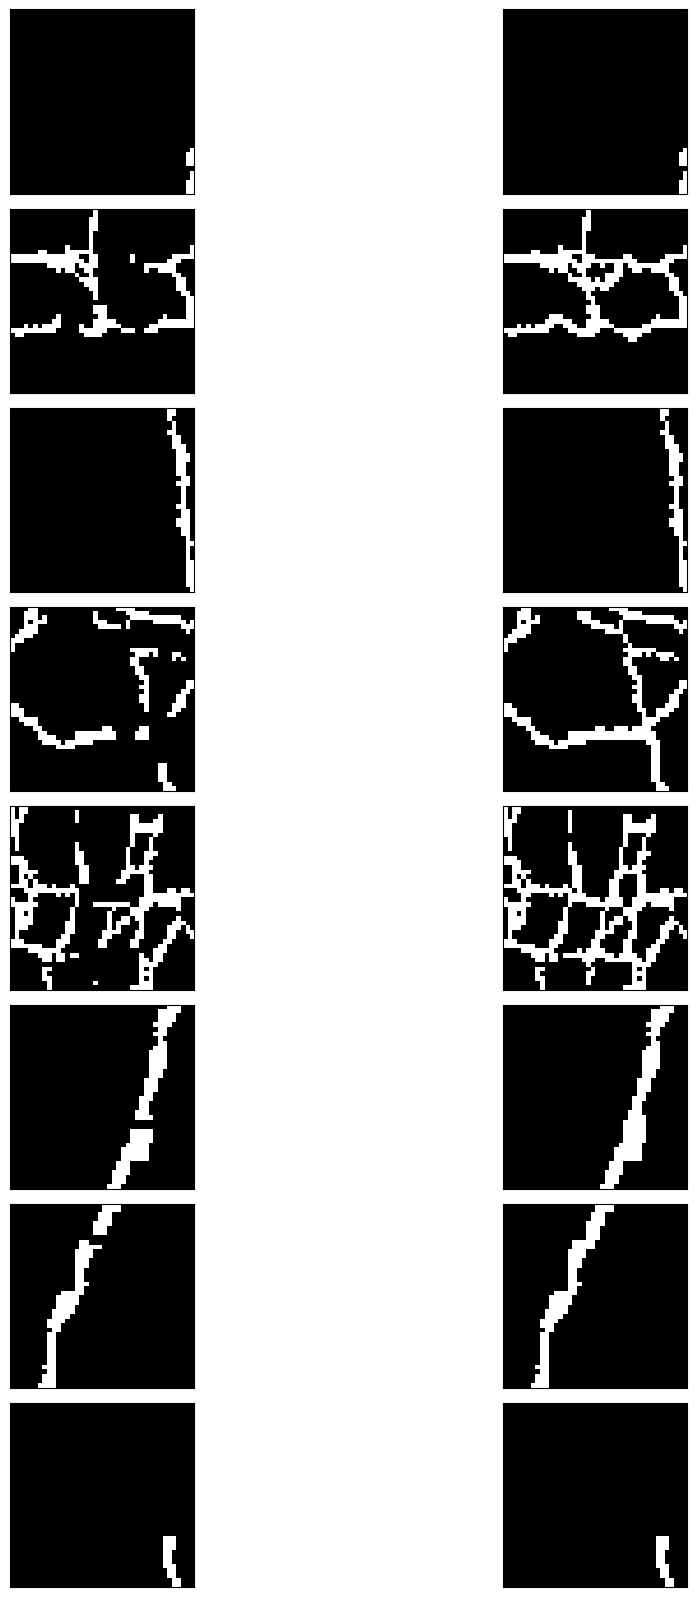

In [13]:
noise_transformations = A.Compose([
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=1),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=1),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=0.6),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=0.6)
])

train_loader, val_loader, test_loader = get_learn_data("data/CrackTree/CRACK500", "train_gt", "val_gt", "test_gt", 
                                                       None, "val", "test", noise_transformations=noise_transformations, 
                                                       patch_mode="keep", img_size=(40, 40), batch_size=32)

fig = plt.figure(figsize=(10, 32))
for idx in np.arange(8):
    noised_image, gt_image, img_name, patch_num = val_loader.dataset[idx + 32]

    # noised input
    ax1 = fig.add_subplot(16, 2, 2 * idx + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_image), cmap='grey')

    # gt image
    ax3 = fig.add_subplot(16, 2, 2 * idx + 2, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_image), cmap='grey')

    fig.tight_layout()
plt.show()

### Betti Number Error Example

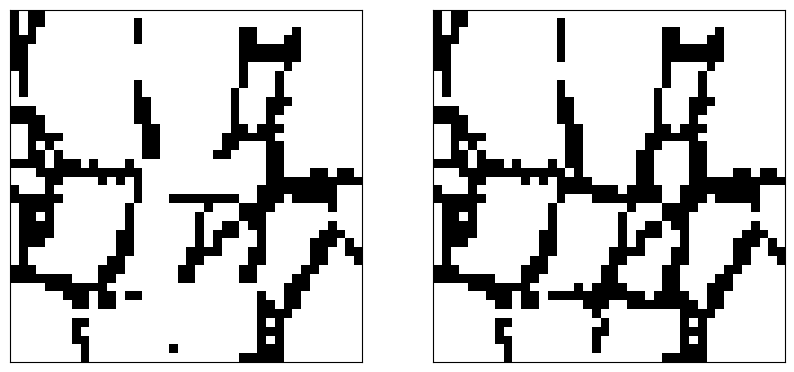

In [7]:
gt_img =  val_loader.dataset[36][1]
noised_img =  val_loader.dataset[36][0]

fig = plt.figure(figsize=(10, 32))

ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(1 - noised_img), cmap='grey')

ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(np.squeeze(1 - gt_img), cmap='grey')

plt.show()

In [8]:
TopoImage(gt_img).betti_numbers()

[4, 11, 0]

In [9]:
TopoImage(noised_img).betti_numbers()

[9, 8, 0]

### Only BCELoss

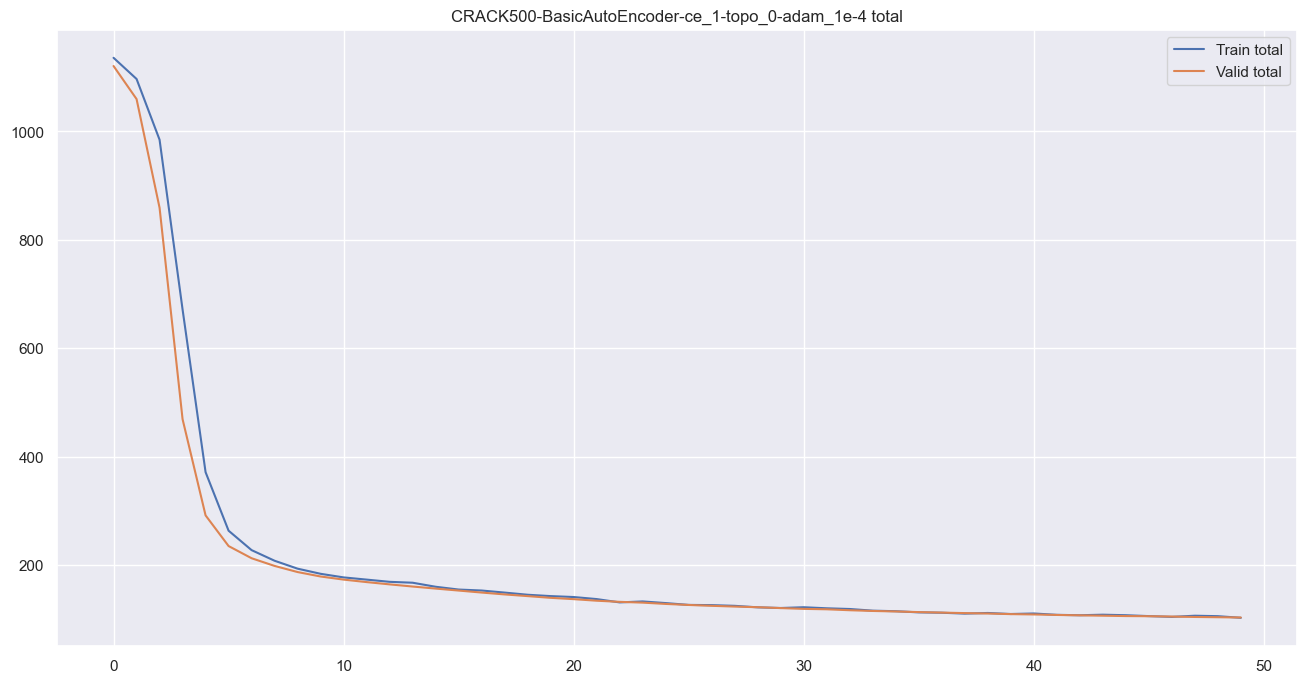

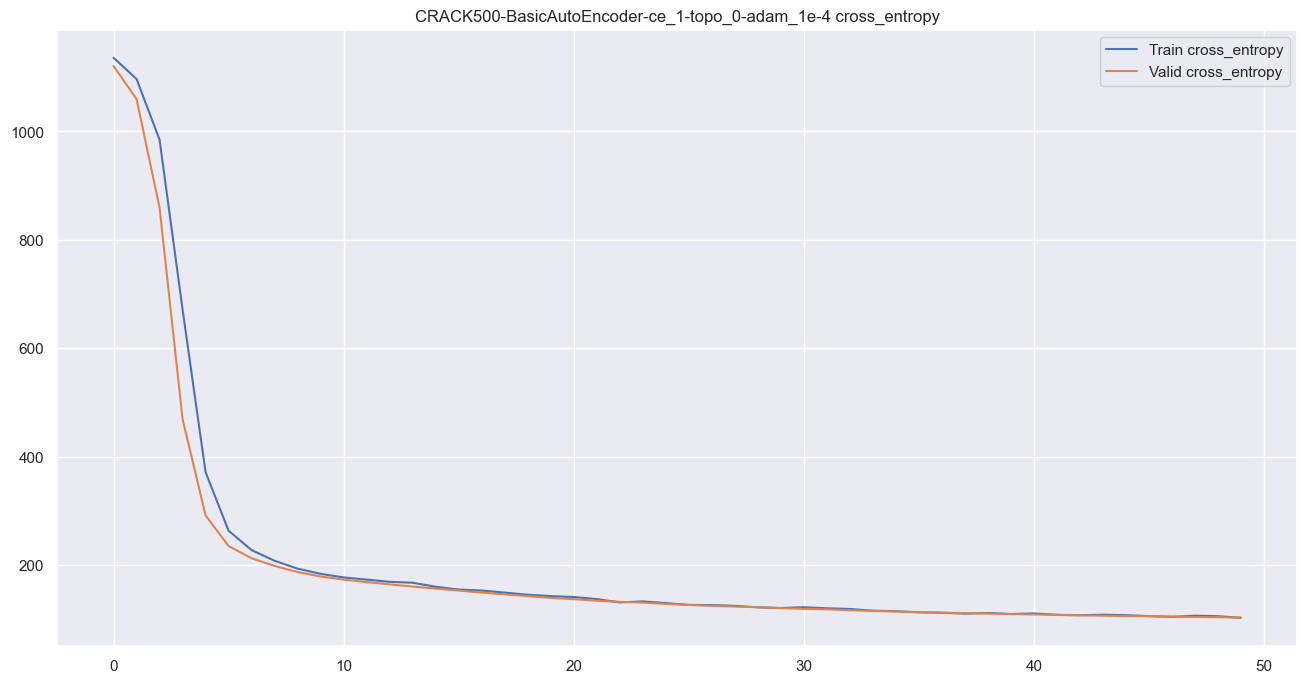

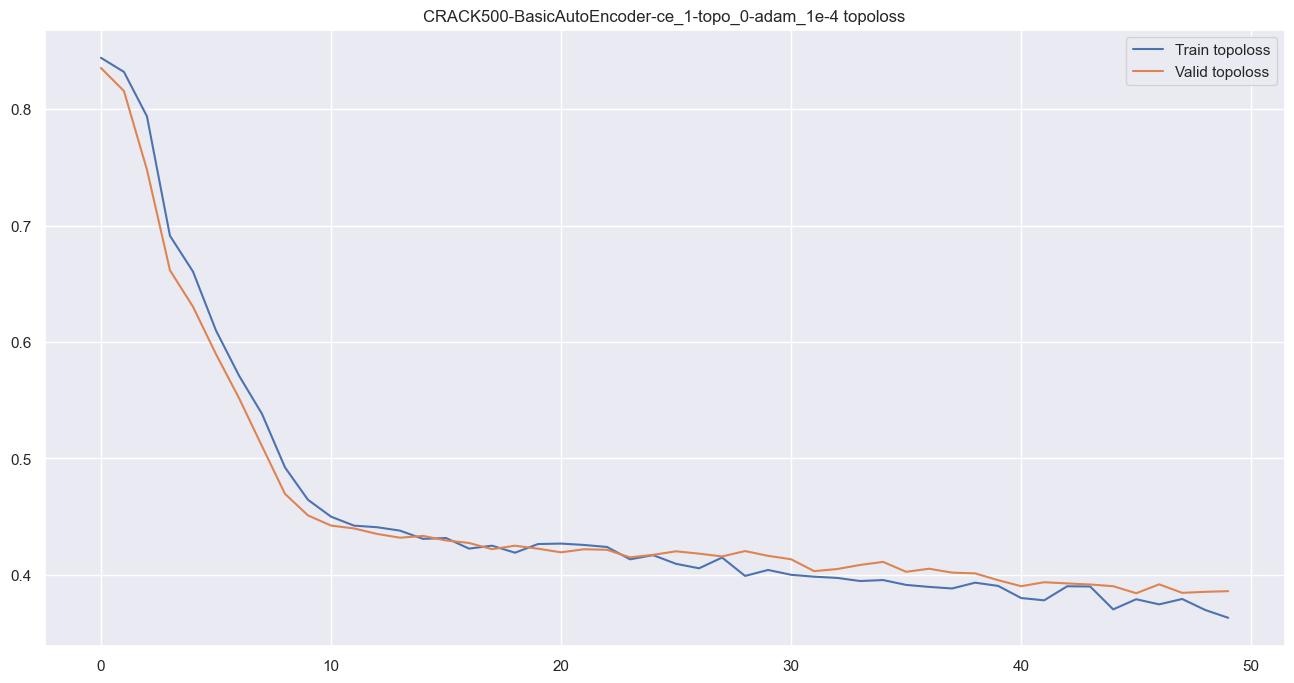

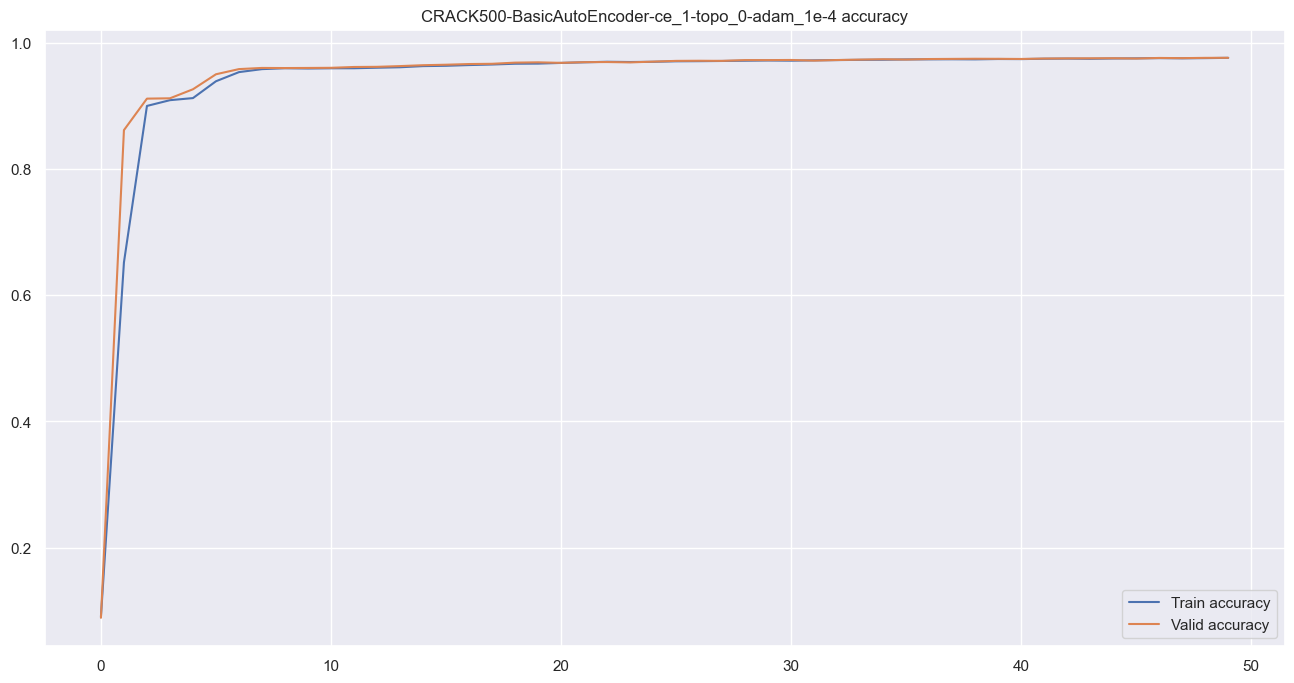

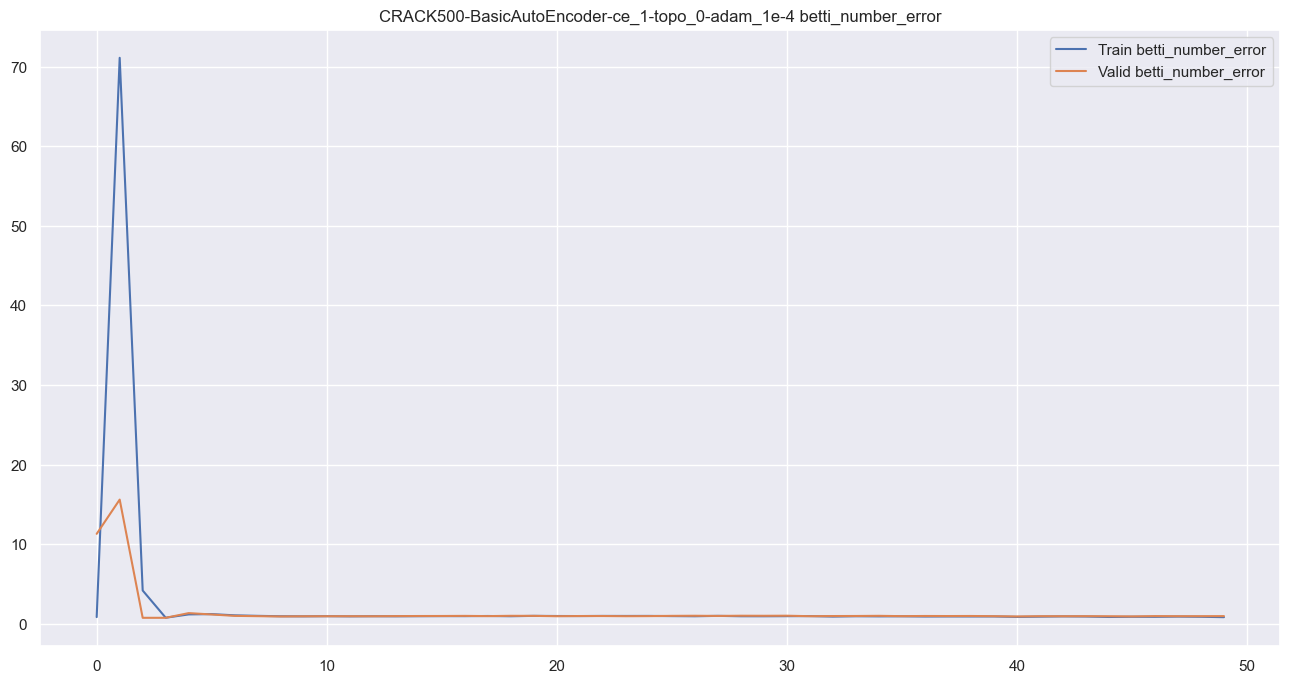

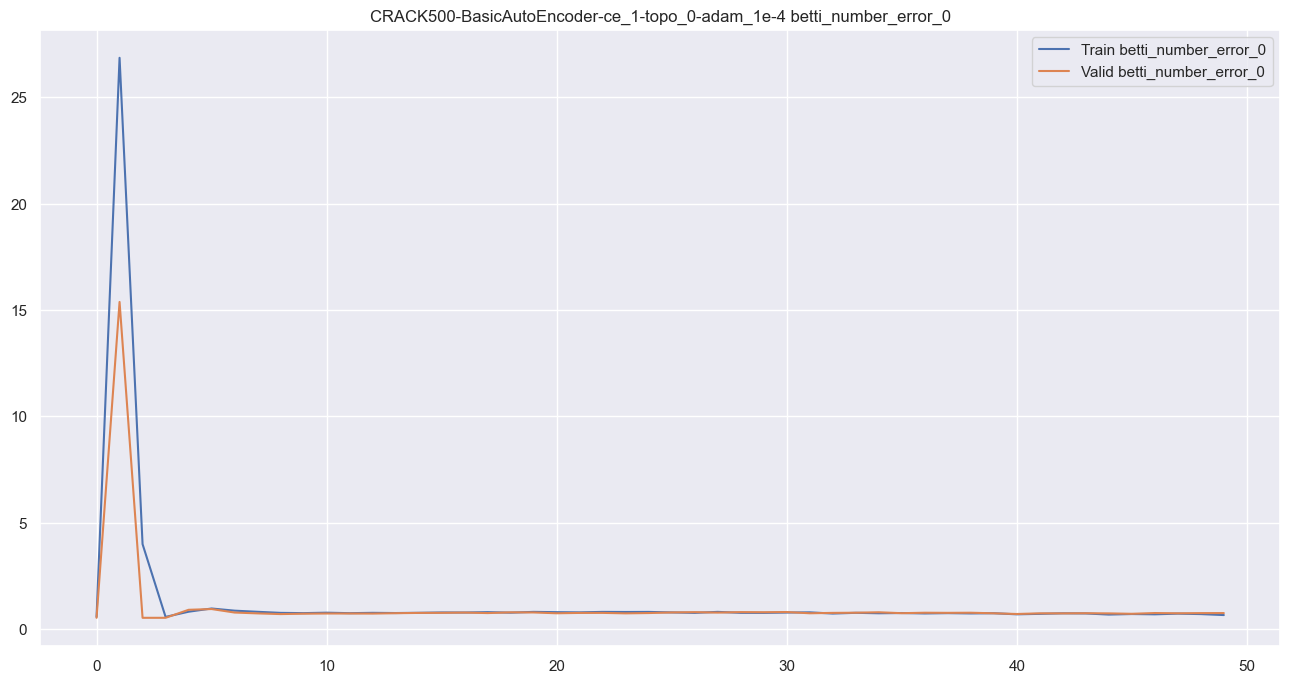

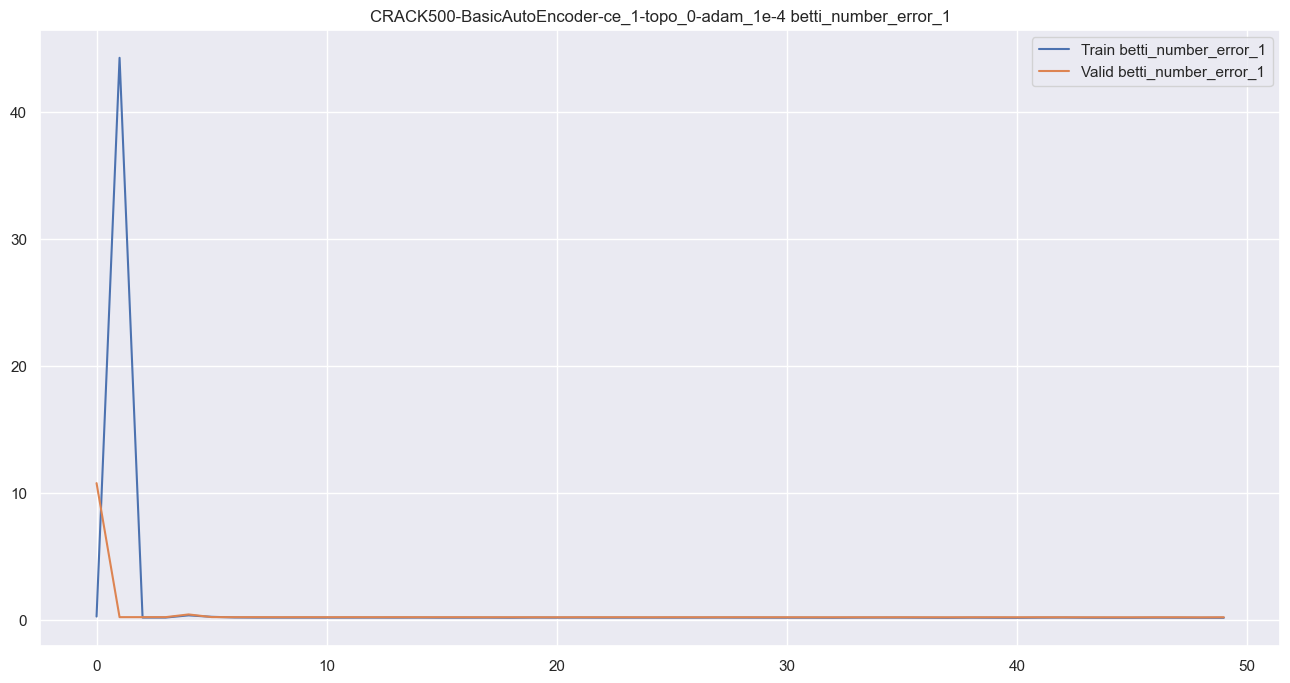

Epoch 49
 train loss: {'total': 102.30146702712145, 'cross_entropy': 102.30146702712145, 'topoloss': 0.3630867176693414}, train metrics: {'accuracy': 0.9757989006421538, 'betti_number_error': 0.8220415537488708, 'betti_number_error_0': 0.6522131887985546, 'betti_number_error_1': 0.16982836495031617}
 val loss: {'total': 102.84991896562076, 'cross_entropy': 102.84991896562076, 'topoloss': 0.38597685519006325}, val metrics: {'accuracy': 0.9758578122847765, 'betti_number_error': 0.9547920433996383, 'betti_number_error_0': 0.7450271247739603, 'betti_number_error_1': 0.20976491862567812}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0001


In [96]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, save_checkpoints=False, save_path="", log_wandb=True)

100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


{'accuracy': 0.97426782015859, 'betti_number_error': 0.9187725631768953, 'betti_number_error_0': 0.6787003610108303, 'betti_number_error_1': 0.24007220216606498}


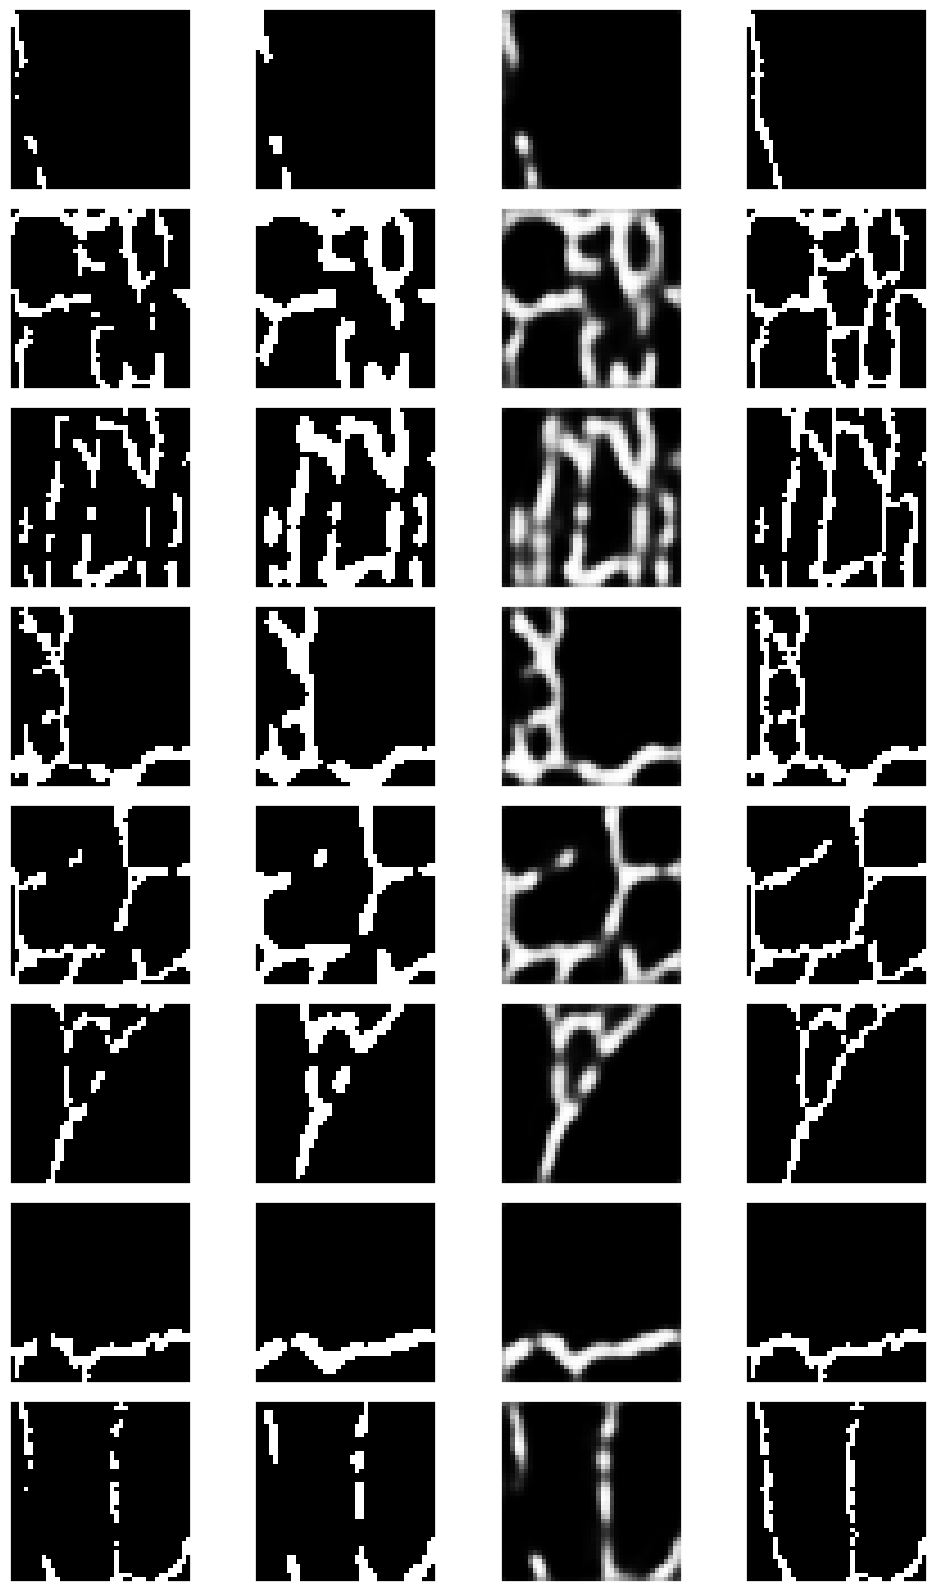

In [98]:
results_1, results_proba_1 = evaluate_model(net, test_loader, device, start_ind=32)

### 1-e4 * BCELoss + TopoLoss

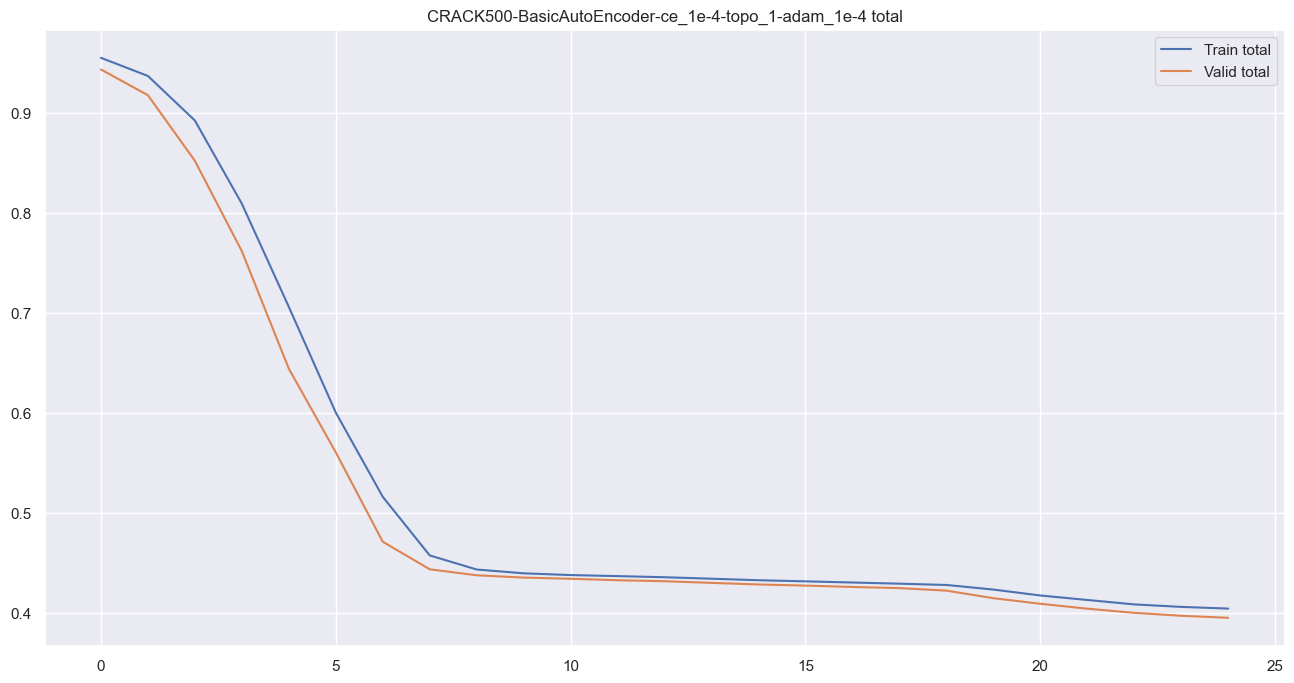

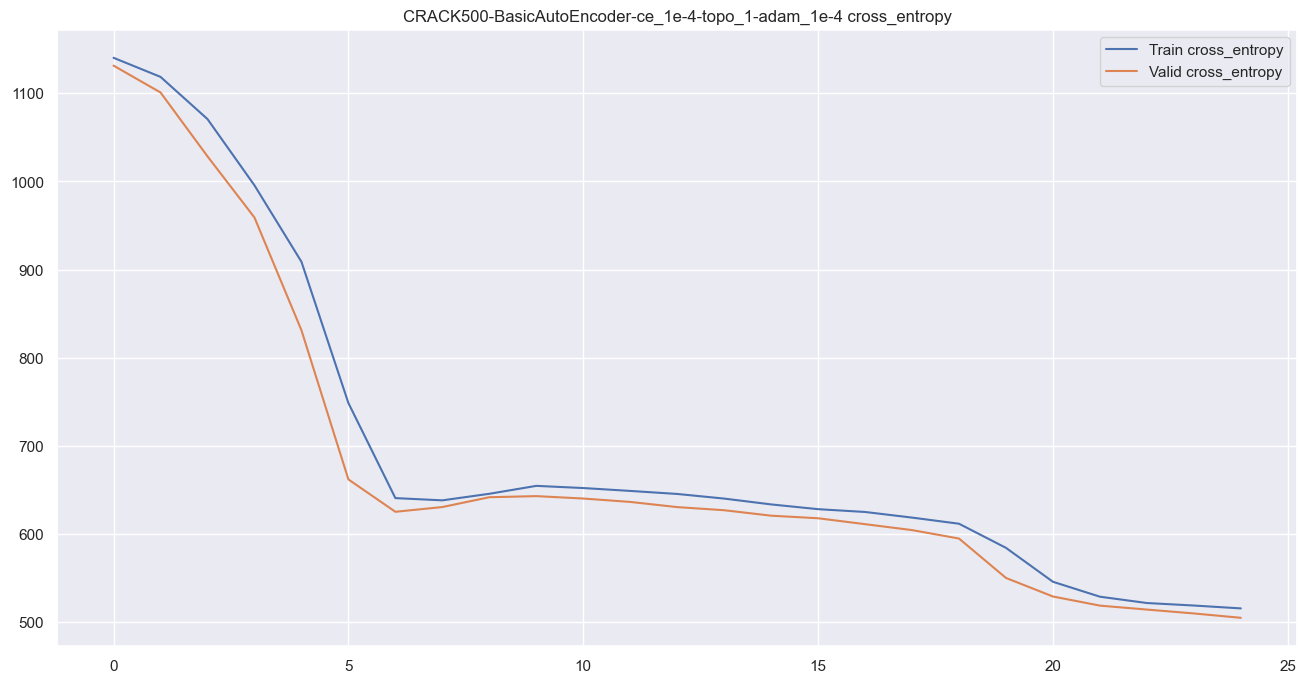

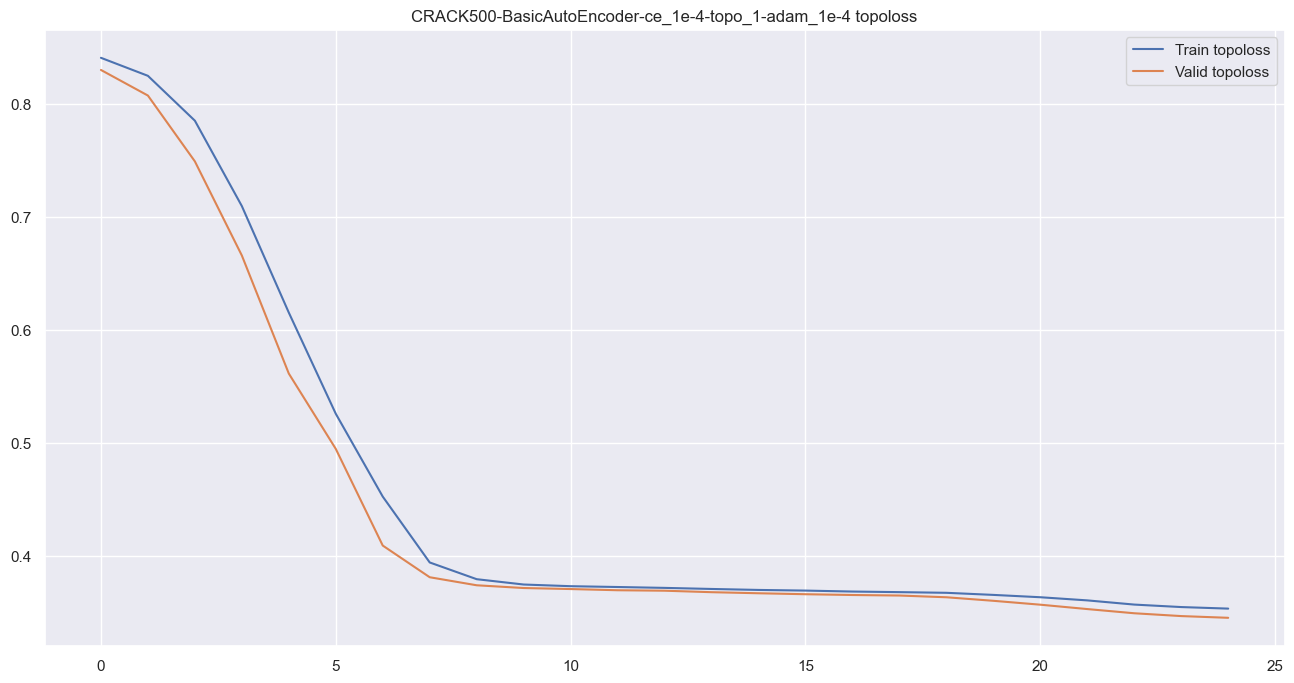

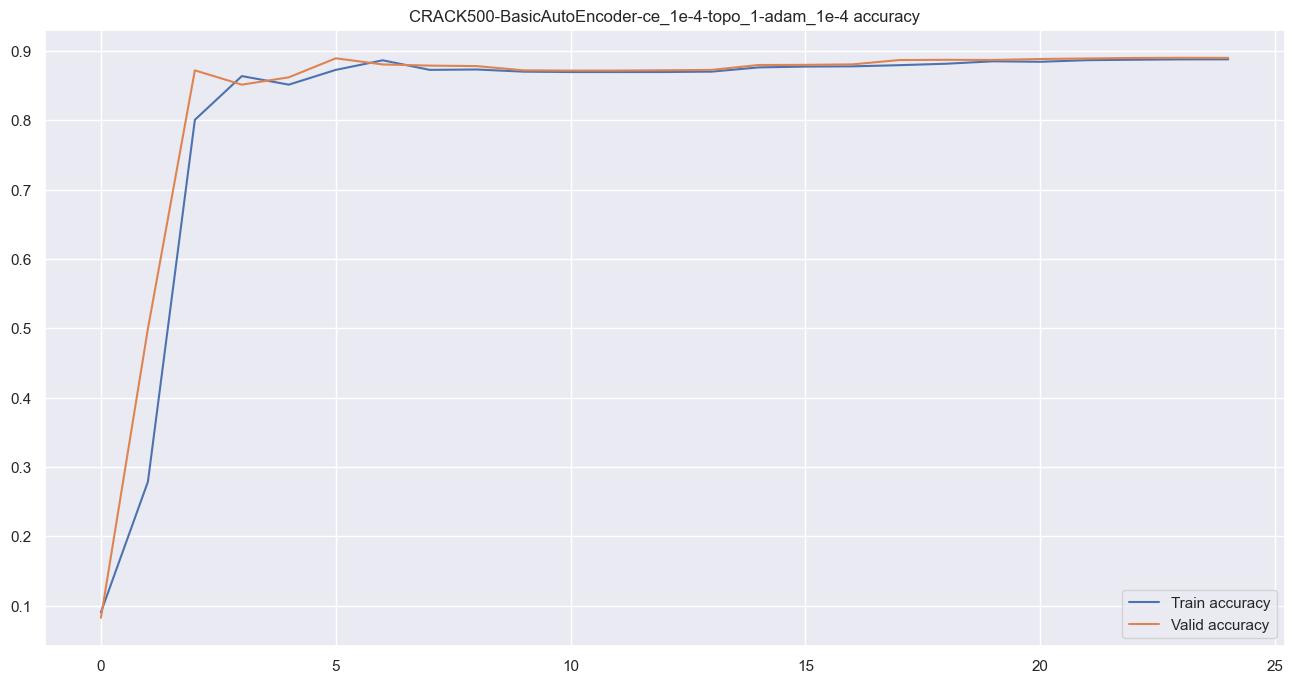

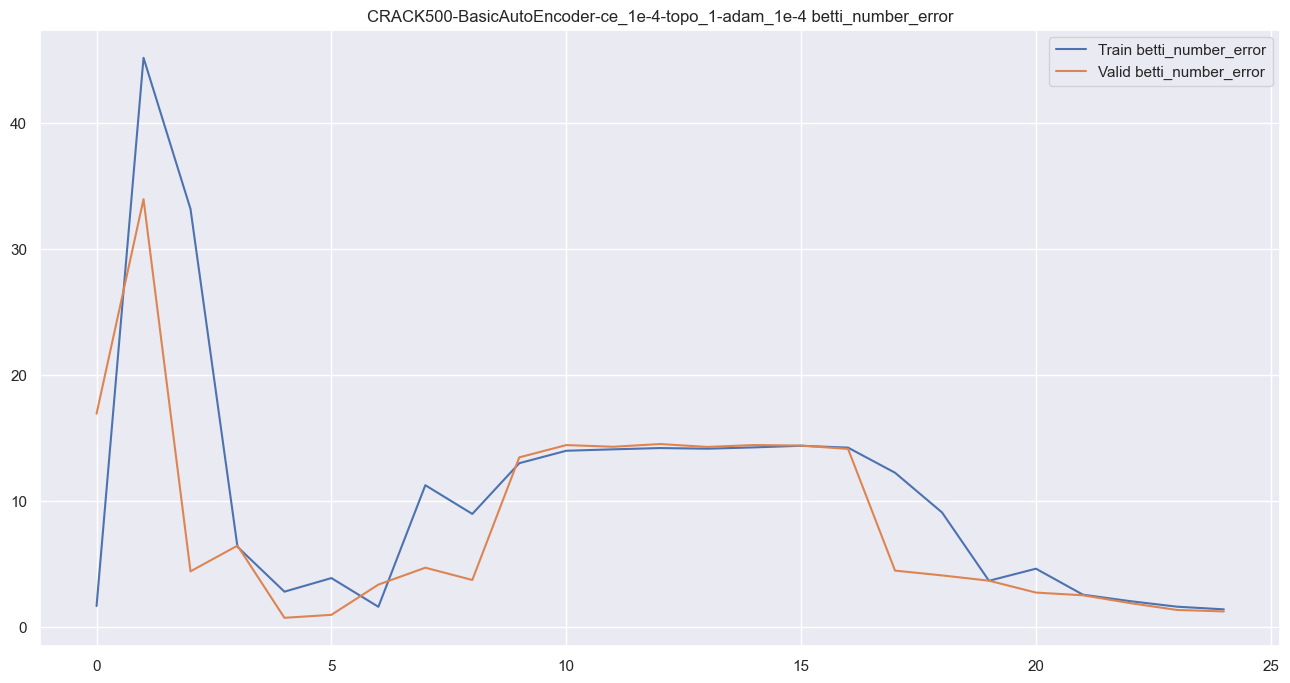

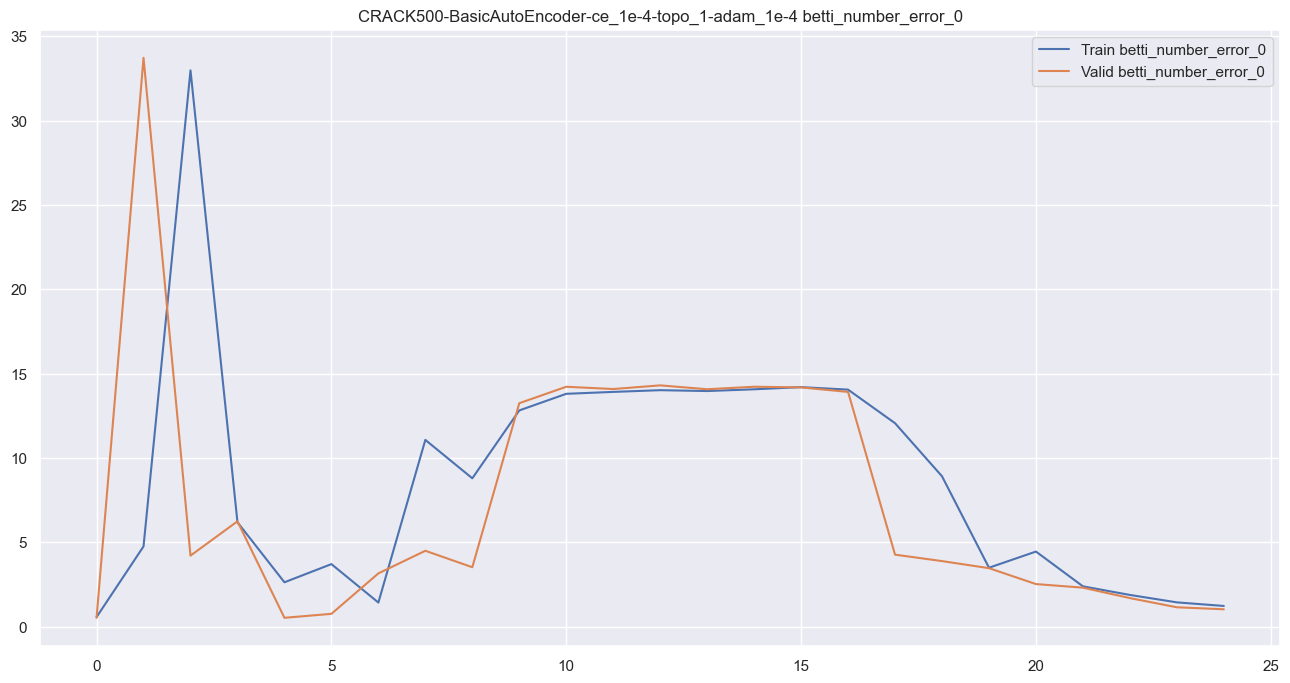

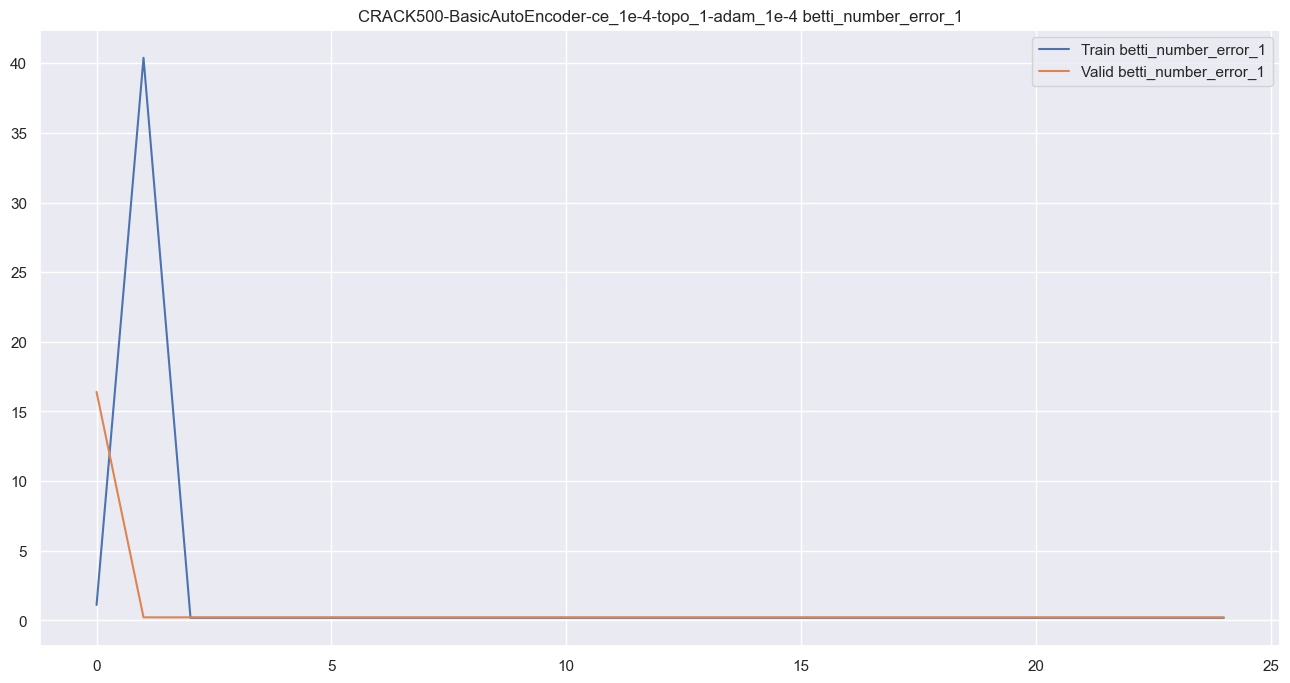

Epoch 24
 train loss: {'total': 0.40466986676003336, 'cross_entropy': 515.7017505787037, 'topoloss': 0.3530996937738848}, train metrics: {'accuracy': 0.8876625998341079, 'betti_number_error': 1.4110207768744354, 'betti_number_error_0': 1.2249322493224932, 'betti_number_error_1': 0.1860885275519422}
 val loss: {'total': 0.39545428343319333, 'cross_entropy': 505.028573724288, 'topoloss': 0.34495142872898316}, val metrics: {'accuracy': 0.8898078666673216, 'betti_number_error': 1.2459312839059675, 'betti_number_error_0': 1.027124773960217, 'betti_number_error_1': 0.21880650994575046}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0001


In [99]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1e-4,
    lambda_topo=1,
    batch_size=32,
    epochs=25,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1e-4-topo_1-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, save_checkpoints=False, save_path="", log_wandb=True)

100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


{'accuracy': 0.8831701330329537, 'betti_number_error': 1.3357400722021662, 'betti_number_error_0': 1.095667870036101, 'betti_number_error_1': 0.24007220216606498}


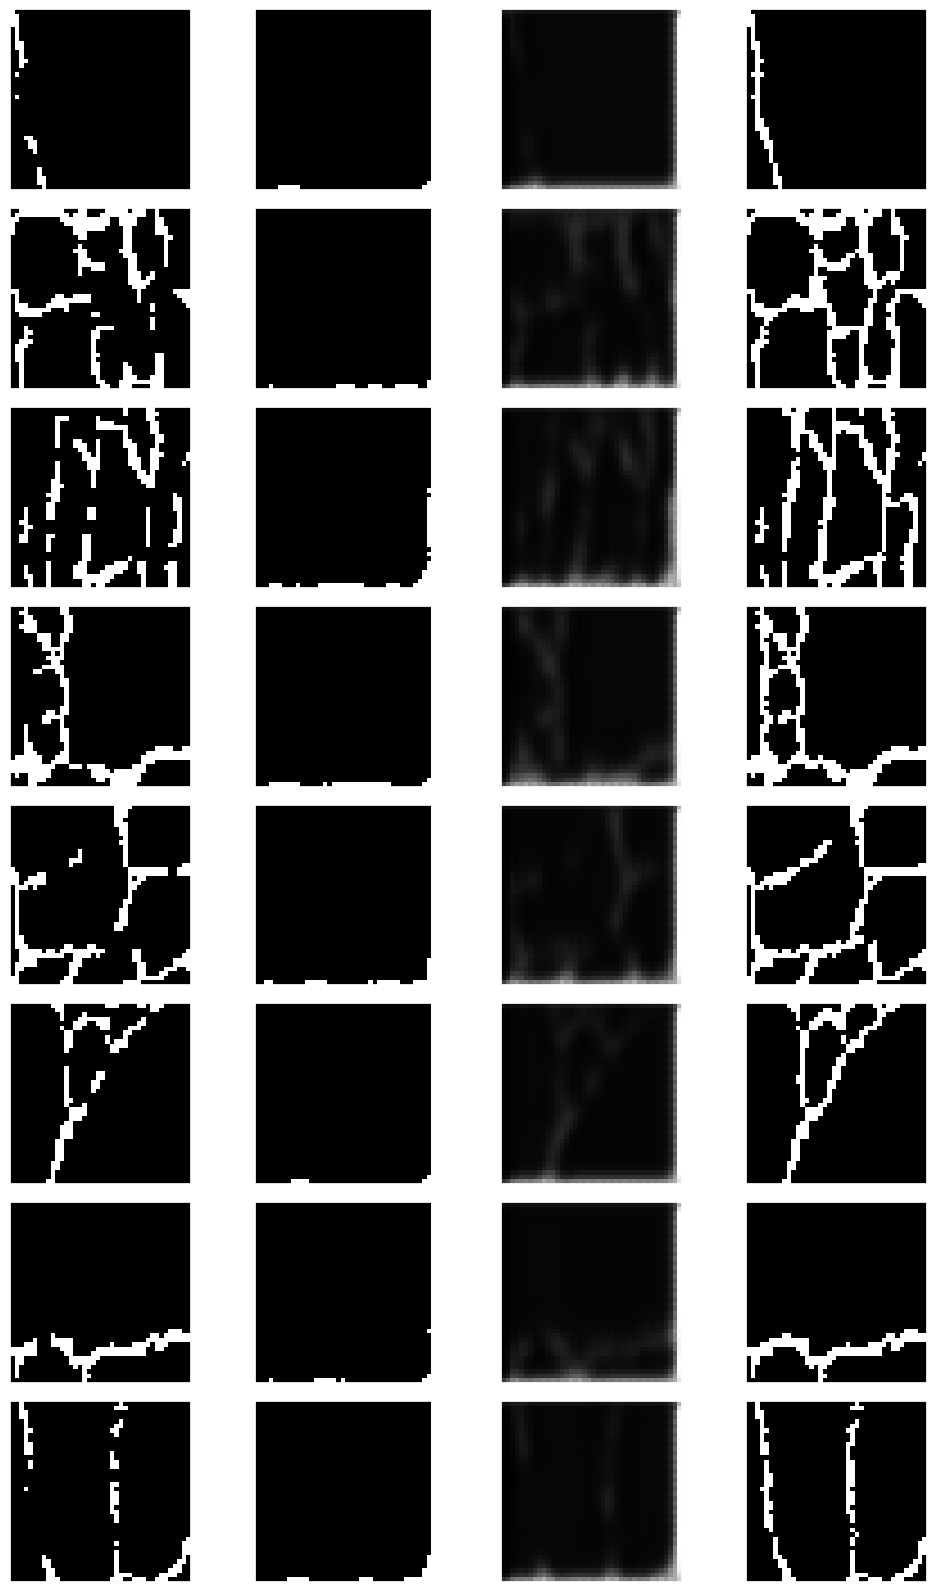

In [101]:
results_2, resluts_prob_2 = evaluate_model(net, test_loader, device, start_ind=32)

### 1-e3 * BCELoss + TopoLoss

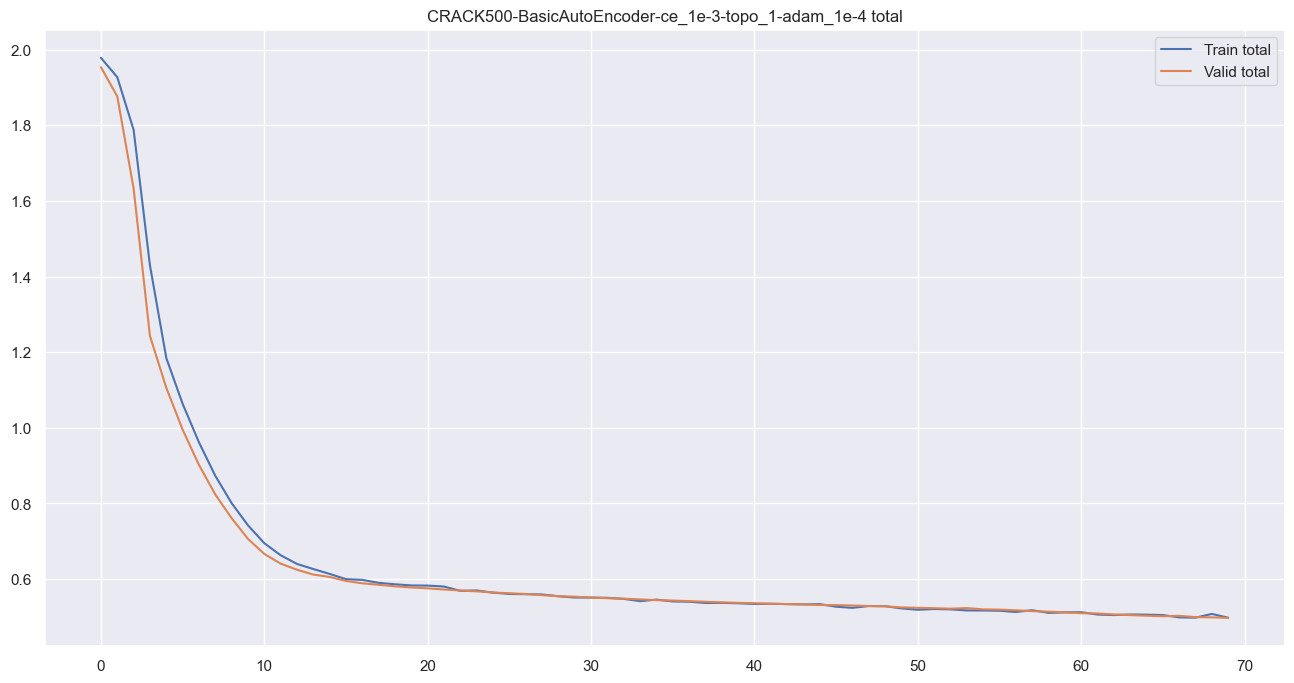

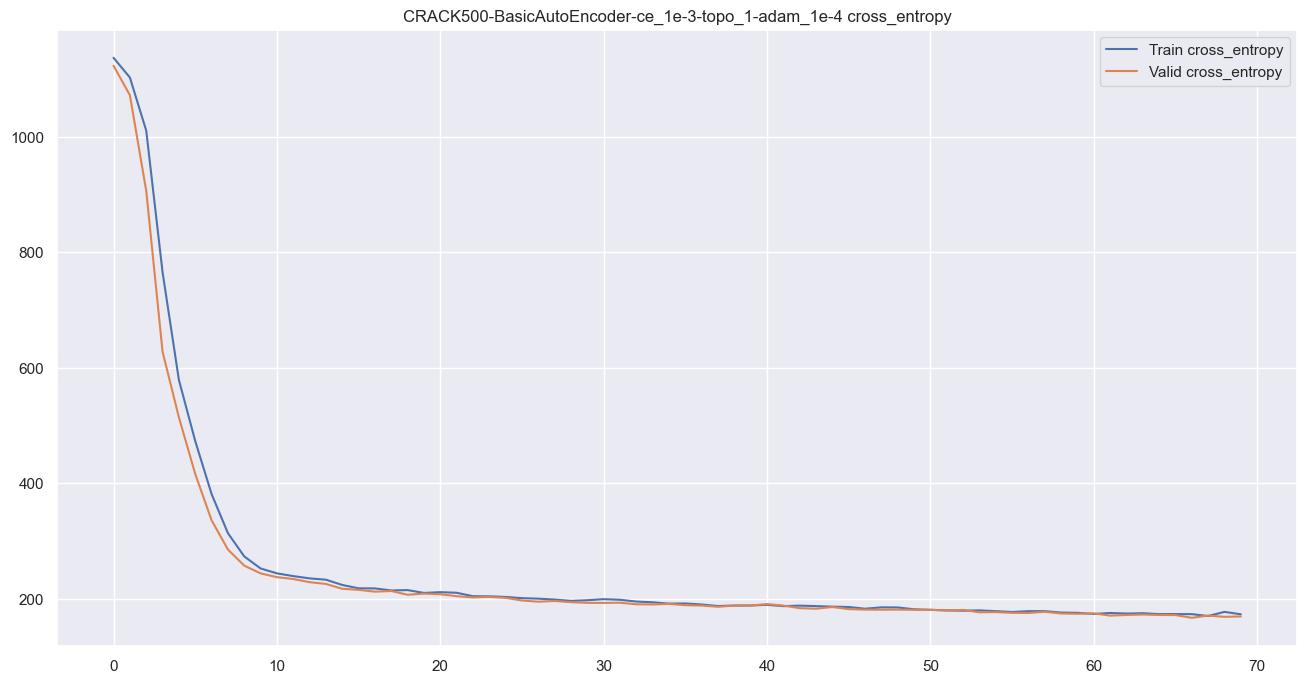

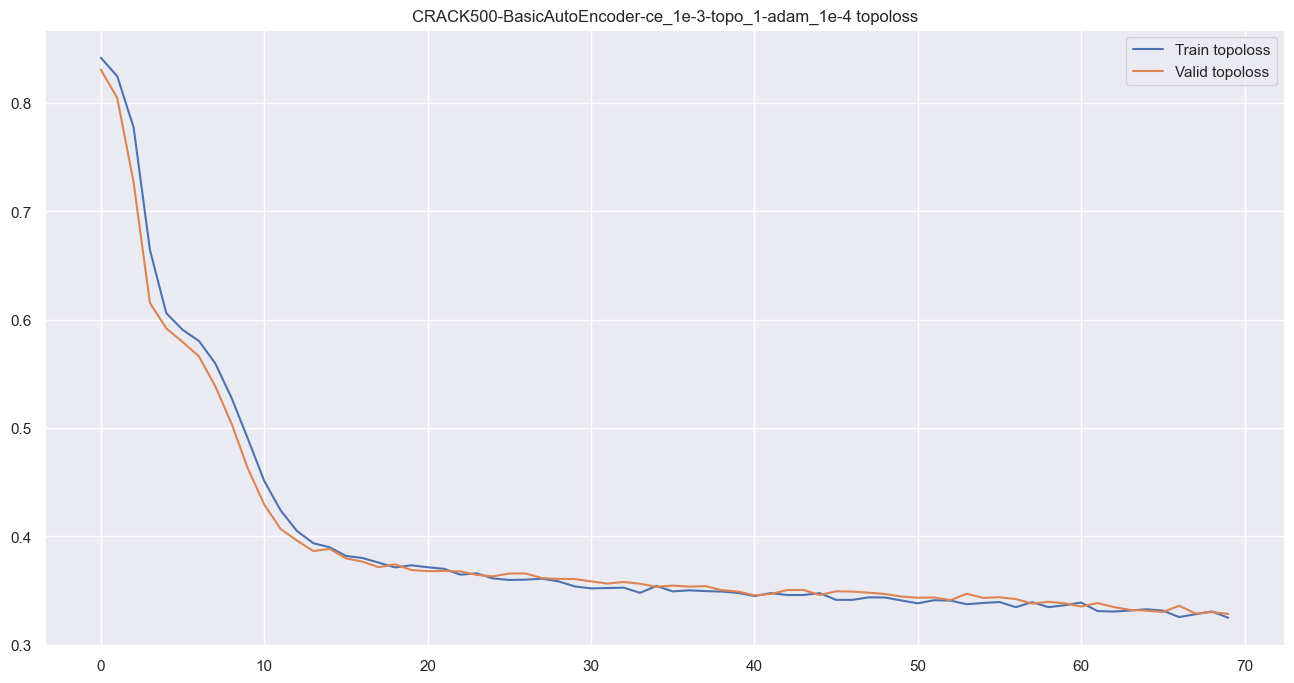

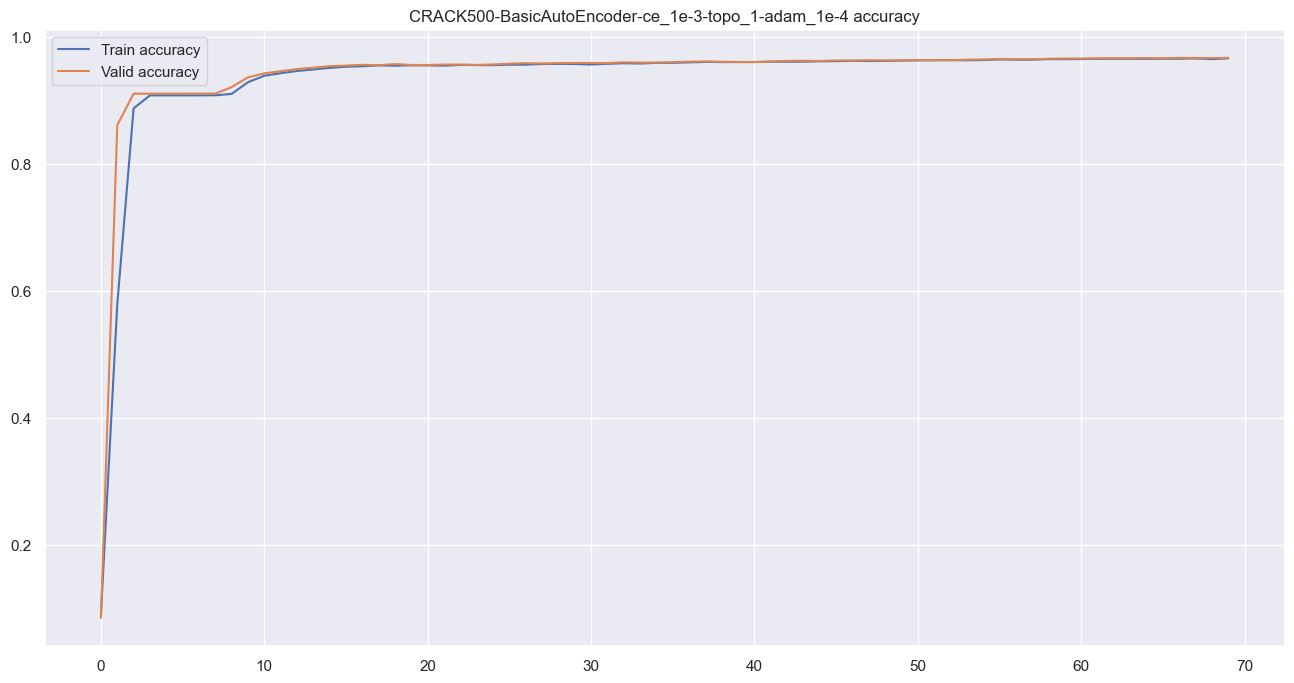

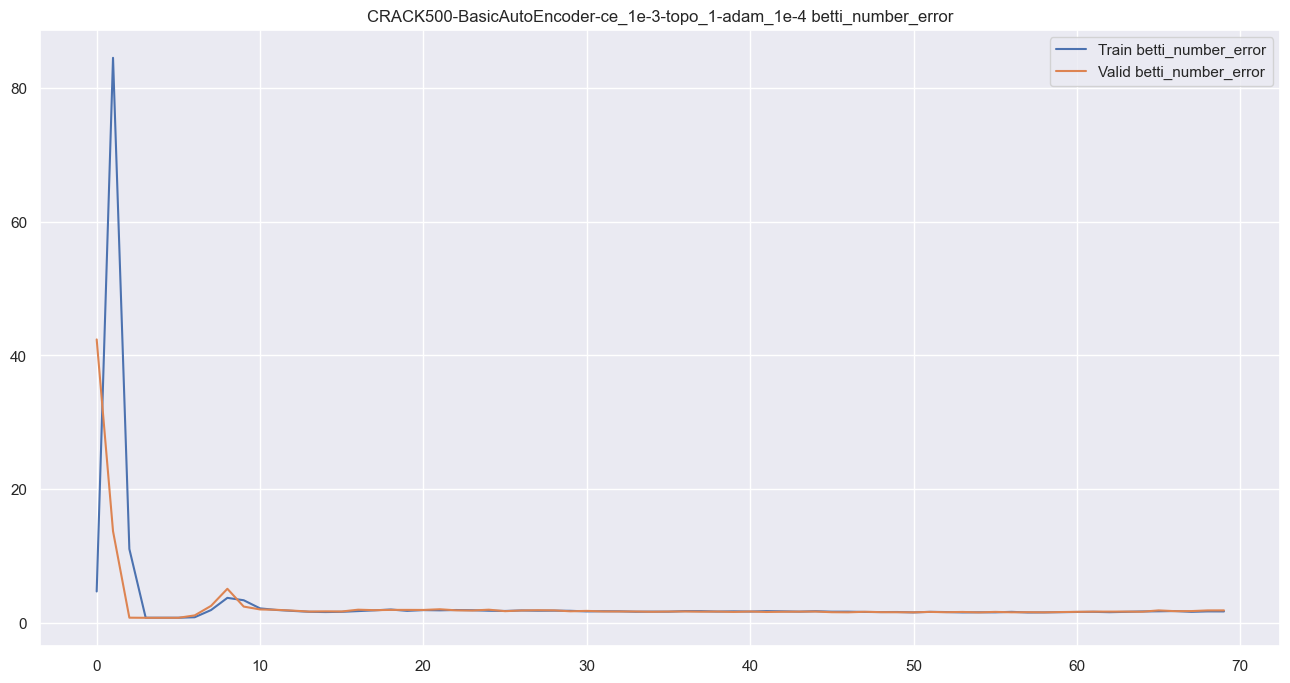

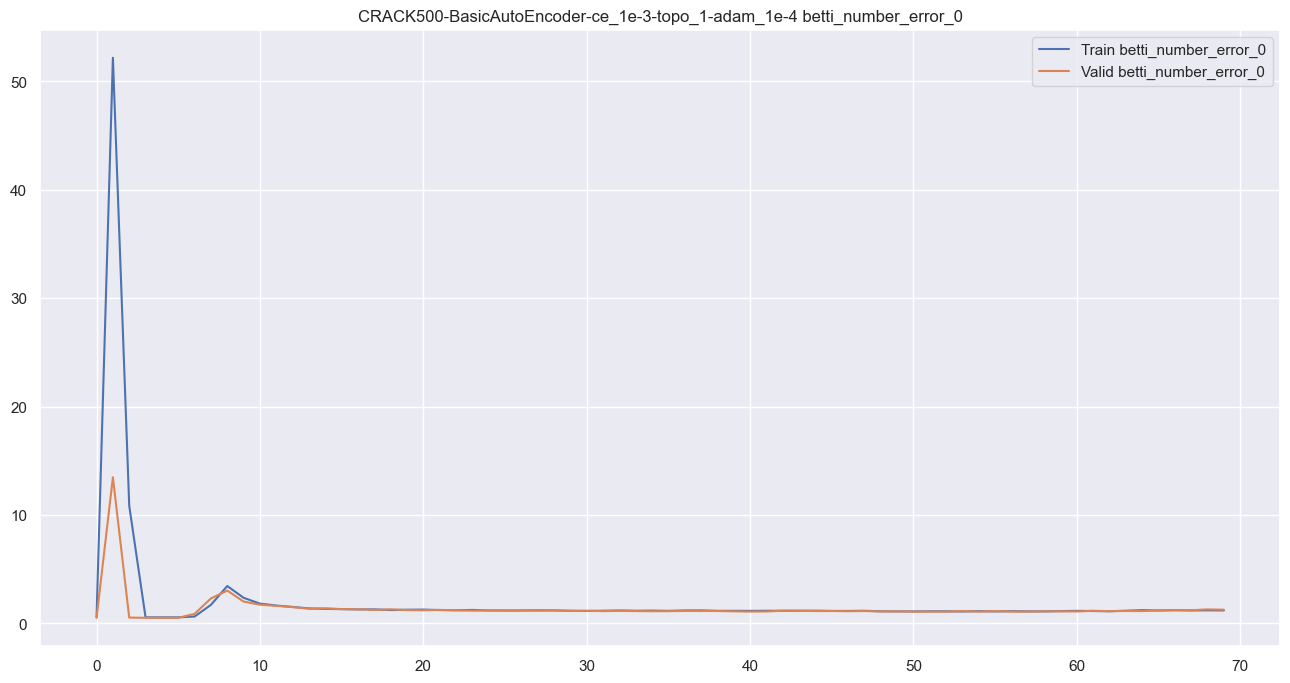

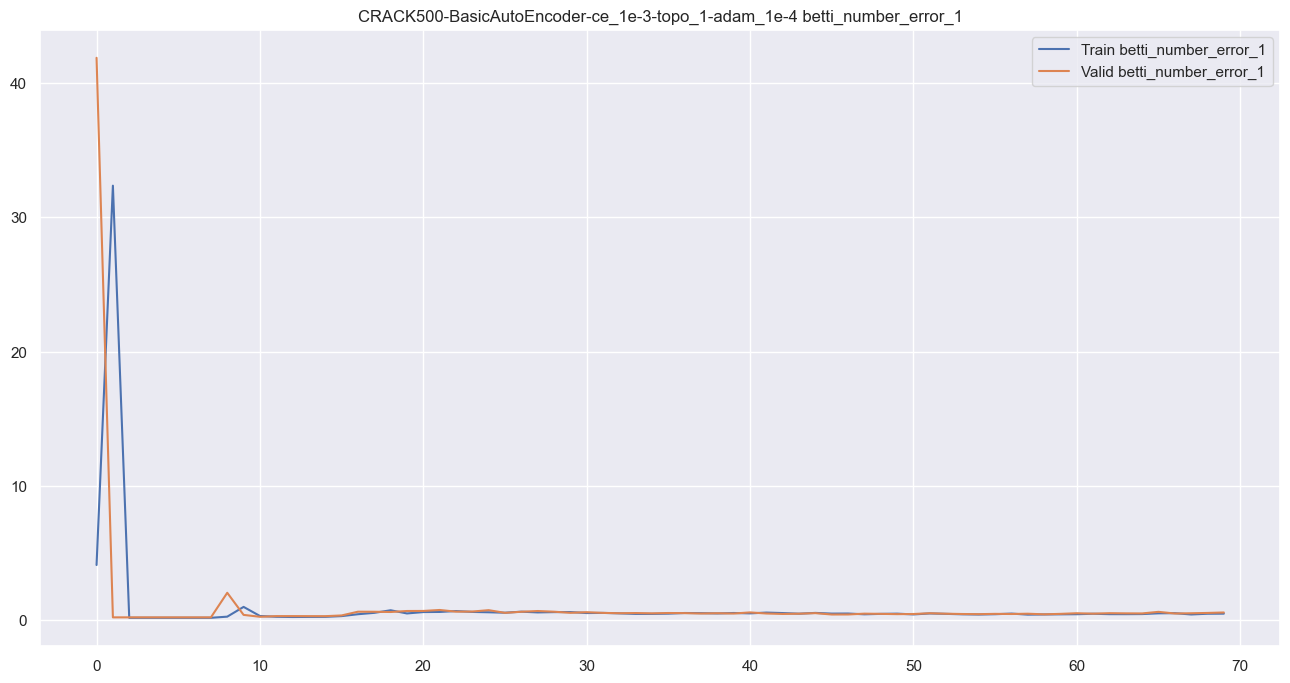

Epoch 69
 train loss: {'total': 0.49778361695245676, 'cross_entropy': 172.8473267594004, 'topoloss': 0.3249362830977884}, train metrics: {'accuracy': 0.9668462110621066, 'betti_number_error': 1.6964769647696476, 'betti_number_error_0': 1.2005420054200542, 'betti_number_error_1': 0.4959349593495935}
 val loss: {'total': 0.4976238618060866, 'cross_entropy': 169.12266101802666, 'topoloss': 0.3285011926137086}, val metrics: {'accuracy': 0.9675259874699129, 'betti_number_error': 1.8517179023508137, 'betti_number_error_0': 1.2694394213381555, 'betti_number_error_1': 0.5822784810126582}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0001


In [102]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1e-3,
    lambda_topo=1,
    batch_size=32,
    epochs=70,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1e-3-topo_1-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, save_checkpoints=False, save_path="", log_wandb=True)

100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


{'accuracy': 0.9652019424989335, 'betti_number_error': 1.8140794223826715, 'betti_number_error_0': 1.259927797833935, 'betti_number_error_1': 0.5541516245487365}


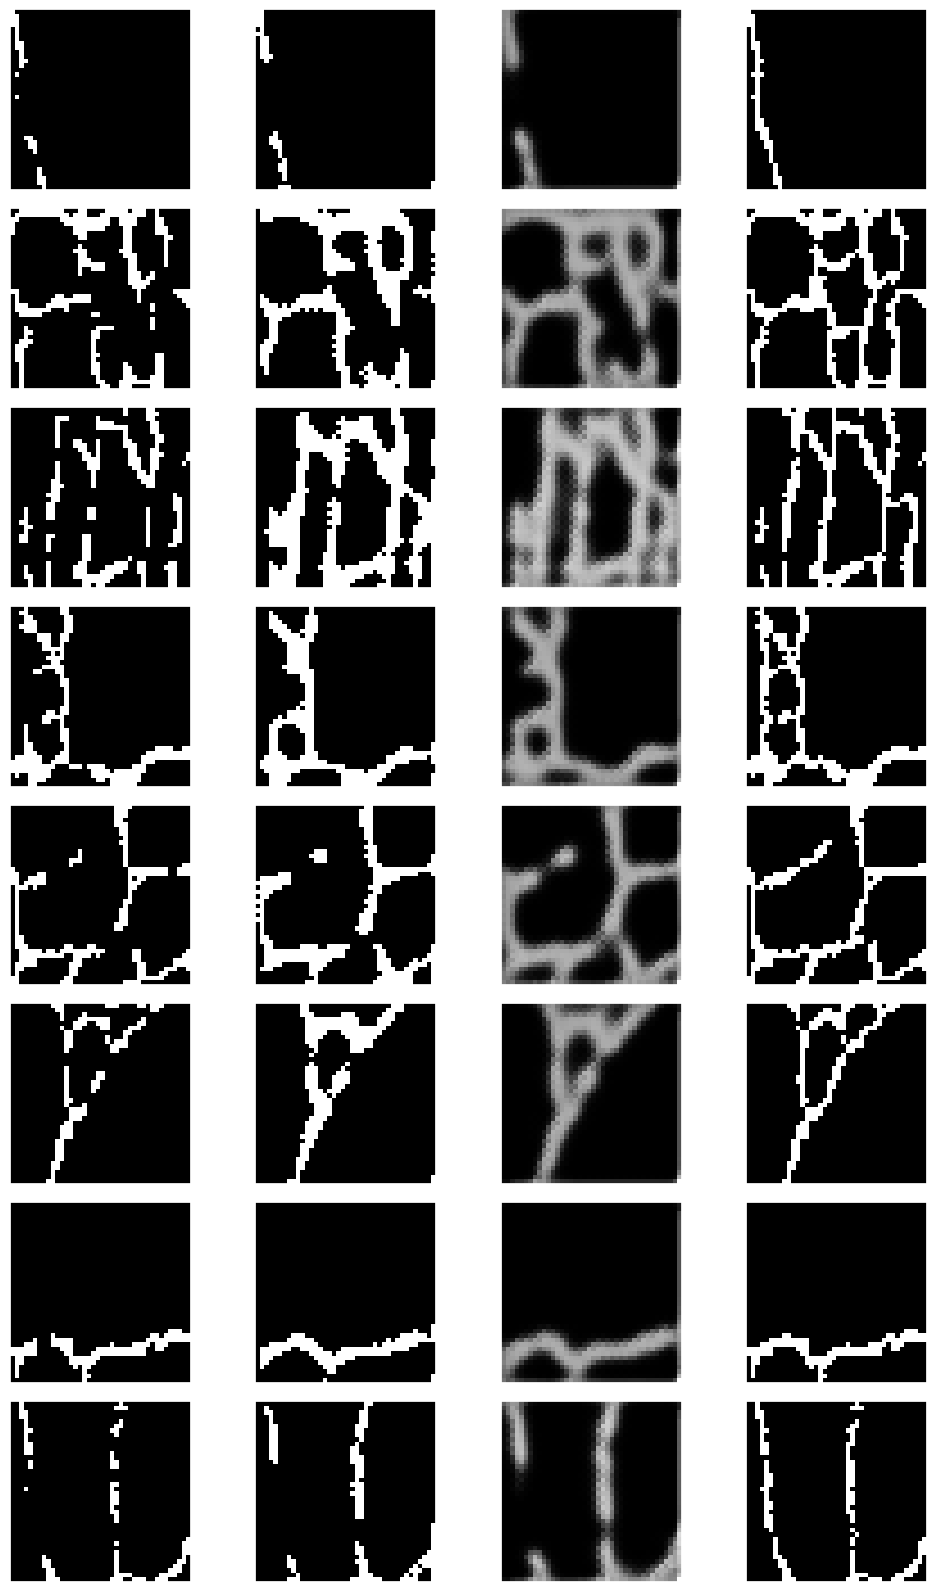

In [103]:
results_3, results_probs_3 = evaluate_model(net, test_loader, device, start_ind=32)

100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


{'accuracy': 0.9625045091236542, 'betti_number_error': 1.4350180505415162, 'betti_number_error_0': 1.03971119133574, 'betti_number_error_1': 0.3953068592057762}


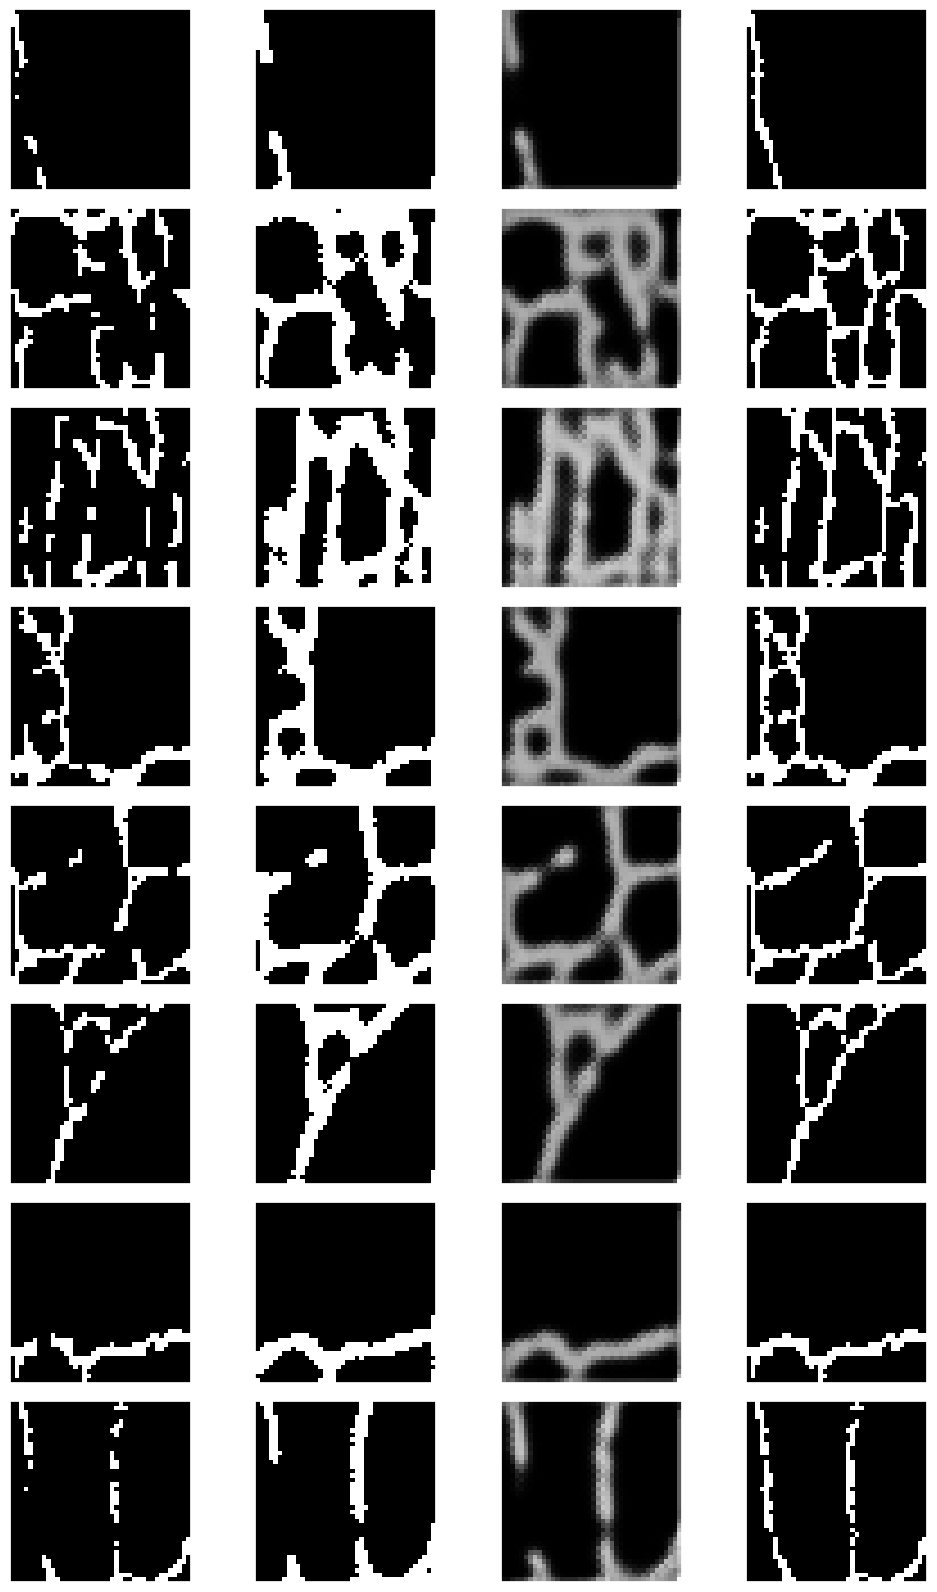

In [107]:
results_3, results_probs_3 = evaluate_model(net, test_loader, device, threshold=0.4, start_ind=32)